In [1]:
import numpy as np
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as mnp
import matplotlib.pyplot as plt
from mindspore import ms_function

In [2]:
class BiLSTM_Attention(nn.Cell):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Dense(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = ops.matmul(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = ops.Softmax(1)(attn_weights)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = ops.matmul(lstm_output.swapaxes(1, 2), soft_attn_weights.expand_dims(2)).squeeze(2)
        return context, soft_attn_weights # context : [batch_size, n_hidden * num_directions(=2)]

    def construct(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.transpose(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input)
        output = output.transpose(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

In [3]:
embedding_dim = 2 # embedding size
n_hidden = 5  # number of hidden units in one cell
num_classes = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

In [4]:
model = BiLSTM_Attention()
criterion = nn.CrossEntropyLoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.001)

In [5]:
inputs = mindspore.Tensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
targets = mindspore.Tensor([out for out in labels], mindspore.int32)

In [6]:
def forward(input, target):
    output, attn = model(input)
    loss = criterion(output, target)
    return loss, attn

In [7]:
grad_fn = ops.value_and_grad(forward, None, optimizer.parameters, has_aux=True)

In [8]:
@ms_function
def train_step(input, target):
    (loss, _), grads = grad_fn(input, target)
    optimizer(grads)
    return loss

In [9]:
model.set_train()
# Training
for epoch in range(5000):
    loss = train_step(inputs, targets)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss.asnumpy()))

Epoch: 1000 cost = 0.004177
Epoch: 2000 cost = 0.000893
Epoch: 3000 cost = 0.000332
Epoch: 4000 cost = 0.000157
Epoch: 5000 cost = 0.000082


In [10]:
# Test
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = mindspore.Tensor(tests)

# Predict
predict, attention = model(test_batch)
predict = predict.argmax(1)

if predict[0] == 0:
    print(test_text,"is Bad Mean...")
else:
    print(test_text,"is Good Mean!!")

sorry hate you is Bad Mean...


/home/lvyufeng/miniconda3/envs/ms1.8/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.
/home/lvyufeng/miniconda3/envs/ms1.8/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


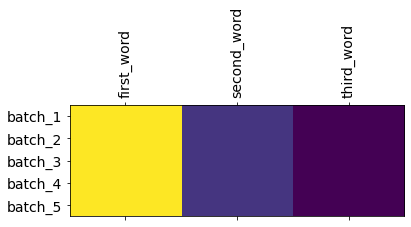

In [11]:
fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention.asnumpy(), cmap='viridis')
ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
plt.show()